### DUAL_STACKED_ENHANCED_Flatten_many_ways_temporal_PatchFormer_classfication_UCI_HAR

- 2025.04.27 ~ 2025.04.30
- PatchFormer 변형

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import os
import zipfile
import urllib.request
from io import BytesIO
from scipy import stats

In [22]:
def load_uci_har_data(data_path):
    # Load activity labels
    activity_labels = pd.read_csv(os.path.join(data_path, 'activity_labels.txt'),
                                 delim_whitespace=True, header=None,
                                 names=['class_index', 'class_name'])

    # Load labels
    y_train = pd.read_csv(os.path.join(data_path, 'y_train.txt'), header=None)
    y_test = pd.read_csv(os.path.join(data_path, 'y_test.txt'), header=None)

    # Convert labels to numpy arrays
    y_train = y_train.values.flatten().astype('int32') - 1  # Make labels zero-indexed
    y_test = y_test.values.flatten().astype('int32') - 1  # Make labels zero-indexed

    # Load inertial signals data
    train_signals_paths = [
        os.path.join(data_path, 'body_acc_x_train.txt'),
        os.path.join(data_path, 'body_acc_y_train.txt'),
        os.path.join(data_path, 'body_acc_z_train.txt'),
        os.path.join(data_path, 'body_gyro_x_train.txt'),
        os.path.join(data_path, 'body_gyro_y_train.txt'),
        os.path.join(data_path, 'body_gyro_z_train.txt'),
        os.path.join(data_path, 'total_acc_x_train.txt'),
        os.path.join(data_path, 'total_acc_y_train.txt'),
        os.path.join(data_path, 'total_acc_z_train.txt')
    ]

    test_signals_paths = [
        os.path.join(data_path, 'body_acc_x_test.txt'),
        os.path.join(data_path, 'body_acc_y_test.txt'),
        os.path.join(data_path, 'body_acc_z_test.txt'),
        os.path.join(data_path, 'body_gyro_x_test.txt'),
        os.path.join(data_path, 'body_gyro_y_test.txt'),
        os.path.join(data_path, 'body_gyro_z_test.txt'),
        os.path.join(data_path, 'total_acc_x_test.txt'),
        os.path.join(data_path, 'total_acc_y_test.txt'),
        os.path.join(data_path, 'total_acc_z_test.txt')
    ]

    # Load and stack training data
    x_train_signals = []
    for path in train_signals_paths:
        signal = pd.read_csv(path, delim_whitespace=True, header=None).values
        x_train_signals.append(signal)

    # Load and stack test data
    x_test_signals = []
    for path in test_signals_paths:
        signal = pd.read_csv(path, delim_whitespace=True, header=None).values
        x_test_signals.append(signal)

    # Convert to numpy arrays with shape (n_samples, n_timestamps, n_features)
    # Each signal has shape (n_samples, n_timestamps)
    # We'll transpose to get shape (n_samples, n_timestamps, n_features)
    x_train = np.transpose(np.array(x_train_signals), (1, 2, 0)).astype('float32')
    x_test = np.transpose(np.array(x_test_signals), (1, 2, 0)).astype('float32')

    print(f"Loaded inertial signals data with shape: {x_train.shape} (train), {x_test.shape} (test)")

    # Normalize each feature independently
    n_samples_train, n_timestamps, n_features = x_train.shape
    n_samples_test = x_test.shape[0]

    # Reshape to normalize features independently
    x_train_reshaped = x_train.reshape((n_samples_train * n_timestamps, n_features))
    x_test_reshaped = x_test.reshape((n_samples_test * n_timestamps, n_features))

    # Normalize
    scaler = StandardScaler()
    x_train_reshaped = scaler.fit_transform(x_train_reshaped)
    x_test_reshaped = scaler.transform(x_test_reshaped)

    # Reshape back to original shape
    x_train = x_train_reshaped.reshape((n_samples_train, n_timestamps, n_features))
    x_test = x_test_reshaped.reshape((n_samples_test, n_timestamps, n_features))

    # One-hot encode labels
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=6)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=6)

    return x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, activity_labels

data_path = "/content/"
x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, activity_labels = load_uci_har_data(data_path)

print ("/content/activity_labels.txt")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")
print("\nActivity labels:")
print(activity_labels)

<ipython-input-22-daf6ec1b3c13>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(os.path.join(data_path, 'activity_labels.txt'),
<ipython-input-22-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).values
<ipython-input-22-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).values
<ipython-input-22-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).

Loaded inertial signals data with shape: (7352, 128, 9) (train), (2947, 128, 9) (test)
/content/activity_labels.txt
Training data shape: (7352, 128, 9)
Training labels shape: (7352, 6)
Test data shape: (2947, 128, 9)
Test labels shape: (2947, 6)

Activity labels:
   class_index          class_name
0            1             WALKING
1            2    WALKING_UPSTAIRS
2            3  WALKING_DOWNSTAIRS
3            4             SITTING
4            5            STANDING
5            6              LAYING


In [23]:
def split_sequences(data, window_size=128, step=64):
    """
    Split the data into sequences with overlapping windows

    Args:
        data: Input data with shape (n_samples, n_features)
        window_size: Number of time steps in each sequence
        step: Step size between consecutive sequences

    Returns:
        Sequences with shape (n_sequences, window_size, n_features)
    """
    n_samples, n_features = data.shape
    sequences = []

    for i in range(0, n_samples - window_size + 1, step):
        sequence = data[i:i + window_size]
        sequences.append(sequence)

    return np.array(sequences)

# -----
# Since the inertial signals data is already in the format of (samples, timestamps, features),
# we don't need to use the split_sequences function for basic formatting, but we'll still use it
# if needed for resizing or overlap

# Check the current shape of the data
print(f"Original training data shape: {x_train.shape}")
print(f"Original test data shape: {x_test.shape}")

# The data already has 128 timestamps per sample, so we can use it directly
# If we need to adjust window size or create overlapping windows:
window_size = 128  # This is already the size in the dataset
step = 128  # Non-overlapping by default - set to smaller value for overlap

# Check if we need to reshape the data
if x_train.shape[1] != window_size or step != window_size:
    print("Reshaping data to adjust window size or create overlapping samples...")
    # Flatten the data to 2D and then recreate sequences
    x_train_flat = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
    x_test_flat = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])

    # Create new sequences
    x_train_seq = split_sequences(x_train_flat, window_size=window_size, step=step)
    x_test_seq = split_sequences(x_test_flat, window_size=window_size, step=step)

    # Create corresponding labels for sequences
    # For each sequence, we'll use the mode of the labels
    orig_samples_per_window = x_train.shape[1] / window_size

    y_train_seq = []
    for i in range(0, len(x_train_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / x_train.shape[1])
        mode_label = y_train[orig_sample_idx]
        y_train_seq.append(mode_label)

    y_test_seq = []
    for i in range(0, len(x_test_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / x_test.shape[1])
        mode_label = y_test[orig_sample_idx]
        y_test_seq.append(mode_label)

    y_train_seq = np.array(y_train_seq)
    y_test_seq = np.array(y_test_seq)
else:
    # If no reshaping is needed, use the data directly
    x_train_seq = x_train
    x_test_seq = x_test
    y_train_seq = y_train
    y_test_seq = y_test

# One-hot encode labels
y_train_seq_onehot = tf.keras.utils.to_categorical(y_train_seq, num_classes=6)
y_test_seq_onehot = tf.keras.utils.to_categorical(y_test_seq, num_classes=6)

print(f"Final training data shape: {x_train_seq.shape}")
print(f"Final training labels shape: {y_train_seq_onehot.shape}")
print(f"Final test data shape: {x_test_seq.shape}")
print(f"Final test labels shape: {y_test_seq_onehot.shape}")


Original training data shape: (7352, 128, 9)
Original test data shape: (2947, 128, 9)
Final training data shape: (7352, 128, 9)
Final training labels shape: (7352, 6)
Final test data shape: (2947, 128, 9)
Final test labels shape: (2947, 6)


---

### Model summary

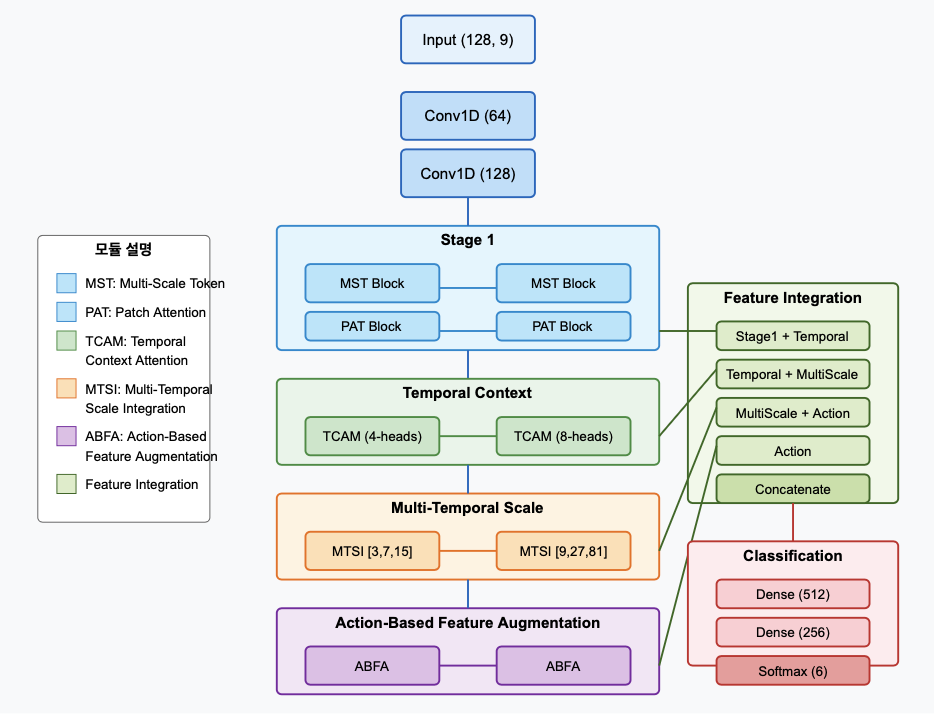

-  **MST Block(Multi-Scale Token)의 필요성**
    - 다양한 시간적 규모의 활동 패턴 포착
      - 인체 활동은 짧은 동작부터 긴 동작까지 다양한 시간적 규모로 이루어짐
      - 여러 커널 크기(3, 5, 7)를 통해 다양한 지속 시간의 패턴을 동시에 인식

    - 센서 데이터 간의 복잡한 상관관계 모델링
      - 9개 축 센서 데이터(가속도계, 자이로스코프) 간의 복잡한 상호작용을 다양한 필터로 포착
      - 각 활동별 센서 패턴의 고유한 특성 파악

<br>

- **PAT Block(Patch Attention)의 필요성**
    - 중요 시간적 패턴에 선택적 집중
      - 활동 인식에서 모든 시점이 동등하게 중요하지 않음
      - 학습된 기본 패치(bases)와의 유사성을 계산하여 핵심 순간에 집중
      - 불필요한 정보 필터링으로 신호 대 잡음비 향상

    - 개인차와 실행 변동성에 강건한 특징 표현
      - 같은 활동이라도 사용자별, 시도별 변동성 존재
      - 본질적인 활동 패턴에 집중하여 개인차나 실행 스타일 차이에 강건한 표현 학습

<br>

- **TCAM(Temporal Context Attention Module)의 필요성**
    - 장거리 시간적 의존성 포착
      - 활동은 시간에 따른 패턴 변화로 이루어짐
      - 멀티헤드 어텐션을 통해 서로 떨어진 시점 간의 관계 파악
      - 전체 활동 맥락 이해로 유사한 동작을 포함하는 서로 다른 활동 구별

    - 양방향 시간적 문맥 통합
      - 현재 시점의 활동을 정확히 해석하기 위해 양방향 LSTM 사용
      - 과거와 미래 문맥을 모두 고려하여 활동 전환 지점 인식
      - 복잡한 동작 시퀀스의 정확한 해석 가능

<br>

- **MTSI(Multi-Temporal Scale Integration)의 필요성**
    - 다양한 시간 스케일의 활동 구성요소 통합
      - 인체 활동은 마이크로 동작(한 걸음)부터 매크로 동작(전체 활동 사이클)까지 다양한 시간 스케일로 구성
      - 여러 시간적 범위의 특징을 통합하여 활동의 전체적인 구조 파악

    - 계층적 시간 패턴 인식
      - 작은 시간 스케일[3,7,15]과 큰 시간 스케일[9,27,81]에서 특징을 단계적으로 추출
      - 점진적으로 더 복잡하고 긴 시간적 패턴 인식
      - 활동 간의 미묘한 시간적 차이 포착

<br>

- **ABFA(Action-Based Feature Augmentation)의 필요성**
    - 활동 클래스별 특징 강화
      - 각 활동 클래스(걷기, 계단 오르기 등)에 대한 프로토타입 특징 학습
      - 클래스 간 구분을 명확히 하여 유사한 활동을 효과적으로 구별
      - 특히 혼동되기 쉬운 활동 쌍(걷기/계단 오르기, 앉기/서기)의 구별 성능 향상

    - 문맥 기반 특징 증강
      - 현재 입력의 활동 확률을 기반으로 특징 증강
      - 클래스 정보를 피드백하여 더 식별력 있는 특징 표현 생성
      - 모델의 확신도에 따라 적응적으로 특징 강화

<br>

- **특징 통합(Feature Integration)의 필요성**
    - 다중 관점 특징 보존
      - 각 모듈(Stage1, Temporal, MultiScale, Action)은
      - 활동을 서로 다른 관점에서 분석
      - 다양한 관점의 특징을 보존하여 종합적인 활동 이해

    - 계층적 특징 결합
      - 낮은 레벨의 공간적 특징부터 높은 레벨의 시간적, 활동 특화 특징까지 다양한 수준의 특징 결합
      - 정보 손실 최소화 및 분류 성능 향상
      - 서로 다른 모듈의 상호 보완적 정보 활용

In [25]:
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        # For each kernel size, create a depthwise conv layer
        self.conv_layers = []

        # Follow the paper's guideline for dimension allocation
        if len(kernel_sizes) == 3:  # Stage-1 with 3 kernel sizes
            self.filter_dims = [filters//4, filters//4, filters//2]  # 32, 32, 64 for filters=128
        else:  # Stage-2/3 with 2 kernel sizes
            self.filter_dims = [filters//2, filters//2]  # 각각 64로 설정하여 합이 128이 되도록 수정

        # Create depthwise convolution for each kernel size
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1,
                    activation=None,
                    name=f'dwconv_{k_size}'
                )
            )

        # Projection layers after each convolution
        self.proj_layers = []
        for i in range(len(kernel_sizes)):
            self.proj_layers.append(
                layers.Conv1D(
                    filters=self.filter_dims[i],
                    kernel_size=1,
                    activation='relu',
                    name=f'proj_{self.kernel_sizes[i]}'
                )
            )

        # Layer normalization
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)

        # Window-based self-attention (W-SA) with relative position bias
        self.attention = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=filters // 4
        )

        # 출력 차원을 명확하게 일치시키기 위한 투영 레이어 추가
        self.output_proj = layers.Conv1D(filters, kernel_size=1, activation=None)

        # MLP after attention
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(filters * 4, activation='relu'),
            layers.Dense(filters)
        ])

    def call(self, inputs):
        # Multi-scale feature aggregation
        x = inputs
        feature_maps = []

        for i, conv_layer in enumerate(self.conv_layers):
            # Apply depthwise convolution
            conv_out = conv_layer(x)
            # Apply projection
            proj_out = self.proj_layers[i](conv_out)
            feature_maps.append(proj_out)

        # Concatenate along feature dimension
        concat_features = tf.concat(feature_maps, axis=-1)

        # 출력 차원을 입력 차원과 정확히 일치시키기 위해 투영
        x = self.output_proj(concat_features)

        # Apply window-based self-attention with relative position bias
        attn_input = self.layer_norm1(x)
        attention_output = self.attention(attn_input, attn_input)
        x = x + attention_output

        # Apply MLP with residual connection
        mlp_input = self.layer_norm2(x)
        mlp_output = self.mlp(mlp_input)
        return x + mlp_output

In [26]:
class PAT_Block(layers.Layer):
    def __init__(self, num_bases=96, **kwargs):
        super(PAT_Block, self).__init__(**kwargs)
        self.num_bases = num_bases

        # Linear layer for query transformation
        self.query_proj = layers.Dense(128, name='query_proj')

        # MLP for base estimation with linear layer and ReLU
        self.base_mlp = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128)
        ], name='base_mlp')

        # Final MLP for output
        self.final_mlp = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128)
        ], name='final_mlp')

    def build(self, input_shape):
        # For simplicity, we'll use fixed bases for all samples in a batch
        # In a complete implementation, this should be dynamic using K-means per sample
        self.bases = self.add_weight(
            name='bases',
            shape=(self.num_bases, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        super(PAT_Block, self).build(input_shape)

    def call(self, inputs):
        # Calculate queries from input
        queries = self.query_proj(inputs)

        # Process bases through the MLP
        processed_bases = self.base_mlp(self.bases)

        # Calculate attention scores between queries and bases
        # Shape: (batch_size, sequence_length, num_bases)
        attention_scores = tf.matmul(queries, tf.transpose(processed_bases))

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Calculate re-estimated features by weighted sum of bases
        # Shape: (batch_size, sequence_length, feature_dim)
        reestimated = tf.matmul(attention_weights, processed_bases)

        # Calculate feature difference (like PCT paper)
        feature_diff = reestimated - inputs

        # Apply final MLP and residual connection
        output = inputs + self.final_mlp(feature_diff)

        return output

In [27]:
class TCAM(layers.Layer):
    """Temporal Context Attention Module"""
    def __init__(self, filters, num_heads=4, **kwargs):
        super(TCAM, self).__init__(**kwargs)
        self.filters = filters
        self.num_heads = num_heads

        # Temporal position encoding
        self.pos_encoding = self.add_weight(
            name='temporal_pos_encoding',
            shape=(1, 128, filters),  # Assuming max 128 timesteps
            initializer='glorot_uniform',
            trainable=True
        )

        # Temporal attention mechanism
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=filters // num_heads
        )

        # Bidirectional feature enhancement for capturing context
        self.bi_lstm = layers.Bidirectional(
            layers.LSTM(filters // 2, return_sequences=True)
        )

        # Normalization and projection
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        # Apply position encoding
        seq_len = tf.shape(inputs)[1]
        pos_enc = self.pos_encoding[:, :seq_len, :]
        x = inputs + pos_enc

        # Capture temporal context via attention
        attn_input = self.layer_norm1(x)
        attn_output = self.mha(attn_input, attn_input)
        x = x + attn_output

        # Enhance with bidirectional context
        lstm_input = self.layer_norm2(x)
        lstm_output = self.bi_lstm(lstm_input)

        # Integrate features and project
        x = x + lstm_output
        x = self.proj(x)
        return x

In [28]:
class MTSI(layers.Layer):
    """Multi-Temporal Scale Integration Module"""
    def __init__(self, filters, scales=[3, 9, 27], **kwargs):
        super(MTSI, self).__init__(**kwargs)
        self.filters = filters
        self.scales = scales

        # Convolutions for various temporal scales
        self.temp_convs = []
        for scale in scales:
            self.temp_convs.append(layers.Conv1D(
                filters=filters // len(scales),
                kernel_size=scale,
                padding='same',
                dilation_rate=1,
                activation='relu'
            ))

        # Multi-scale feature integration
        self.integration = layers.Conv1D(filters, kernel_size=1)
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Extract features at multiple temporal scales
        multi_scale_features = []
        for conv in self.temp_convs:
            multi_scale_features.append(conv(inputs))

        # Integrate features
        x = layers.Concatenate()(multi_scale_features)
        x = self.integration(x)
        x = self.norm(x)

        # Residual connection
        return x + inputs

In [29]:
class ABFA(layers.Layer):
    """Action-Based Feature Augmentation Module"""
    def __init__(self, filters, activity_classes=6, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes

        # Action prototypes (feature prototype for each activity class)
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(activity_classes, filters),
            initializer='glorot_uniform',
            trainable=True
        )

        # Action embedding (class context generation)
        self.embedding_proj = layers.Dense(filters)
        self.attention = layers.Dense(1)

        # Feature augmentation
        self.augment_proj = layers.Dense(filters)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Extract global features by averaging over sequence
        global_feat = tf.reduce_mean(inputs, axis=1, keepdims=True)  # [batch, 1, filters]

        # Calculate similarity with each action prototype
        similarity = tf.matmul(
            tf.squeeze(global_feat, axis=1),  # [batch, filters]
            self.action_prototypes,  # [classes, filters]
            transpose_b=True
        )  # [batch, classes]

        # Calculate action probabilities using softmax
        action_probs = tf.nn.softmax(similarity, axis=-1)  # [batch, classes]

        # Create context based on action probabilities
        context = tf.matmul(
            action_probs,  # [batch, classes]
            self.action_prototypes  # [classes, filters]
        )  # [batch, filters]

        # Embed and expand context
        context = self.embedding_proj(context)  # [batch, filters]

        # Broadcast context to sequence dimension
        context = tf.expand_dims(context, axis=1)  # [batch, 1, filters]
        context = tf.tile(context, [1, tf.shape(inputs)[1], 1])  # [batch, seq_len, filters]

        # Integrate features and context for augmentation
        x = tf.concat([inputs, context], axis=-1)
        x = self.augment_proj(x)
        x = self.layer_norm(x)

        # Preserve original features via residual connection
        return x + inputs

In [30]:
def build_enhanced_patchformer_model(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    stage1_1 = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)
    stage1_1 = PAT_Block(num_bases=96)(stage1_1)

    stage1_2 = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(stage1_1)
    stage1_2 = PAT_Block(num_bases=96)(stage1_2)

    stage1 = layers.add([stage1_2, stage1_1])

    temporal_1 = TCAM(filters=128, num_heads=4)(stage1)

    temporal_2 = TCAM(filters=128, num_heads=8)(temporal_1)

    temporal = layers.add([temporal_2, stage1])

    multi_scale_1 = MTSI(filters=128, scales=[3, 7, 15])(temporal)

    multi_scale_2 = MTSI(filters=128, scales=[9, 27, 81])(multi_scale_1)

    multi_scale = layers.add([multi_scale_2, temporal])

    action_aug_1 = ABFA(filters=128, activity_classes=num_classes)(multi_scale)
    action_aug_1 = layers.Dropout(0.1)(action_aug_1)

    action_aug_2 = ABFA(filters=128, activity_classes=num_classes)(action_aug_1)
    action_aug_2 = layers.Dropout(0.1)(action_aug_2)

    action_aug = layers.add([action_aug_2, multi_scale])

    stage1_temporal = layers.add([stage1, temporal])
    temporal_multiscale = layers.add([temporal, multi_scale])
    multiscale_action = layers.add([multi_scale, action_aug])

    level1_feat = layers.Flatten()(stage1_temporal)
    level2_feat = layers.Flatten()(temporal_multiscale)
    level3_feat = layers.Flatten()(multiscale_action)
    level4_feat = layers.Flatten()(action_aug)

    combined = layers.Concatenate()([level1_feat, level2_feat, level3_feat, level4_feat])

    if input_shape[0] > 64:
        combined = layers.Dense(2048, activation='relu')(combined)

    x = layers.Dense(512, activation=None)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(256, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
model = build_enhanced_patchformer_model(input_shape=(window_size, x_train.shape[2]))
model.summary()

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'abfa_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'abfa_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 128, 128)  │      8,320 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_2        │ (None, 128, 128)  │    233,600 │ activation_5[0][… │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pat__block_2        │ (None, 128, 128)  │     94,848 │ mst__block_2[0][… │
│ (PAT_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_3        │ (None, 128, 128)  │    233,600 │ pat__block_2[0][… │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pat__block_3        │ (None, 128, 128)  │     94,848 │ mst__block_3[0][… │
│ (PAT_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 128, 128)  │          0 │ pat__block_3[0][… │
│                     │                   │            │ pat__block_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcam_2 (TCAM)       │ (None, 128, 128)  │    198,272 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcam_3 (TCAM)       │ (None, 128, 128)  │    198,272 │ tcam_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128)  │          0 │ tcam_3[0][0],     │
│                     │                   │            │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mtsi_2 (MTSI)       │ (None, 128, 128)  │    151,038 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mtsi_3 (MTSI)       │ (None, 128, 128)  │    645,630 │ mtsi_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128, 128)  │          0 │ mtsi_3[0][0],     │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_2 (ABFA)       │ (None, 128, 128)  │     50,432 │ add_9[0][0]     

 Total params: 137,397,634 (524.13 MB)

 Trainable params: 137,395,714 (524.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [32]:
# import tensorflow.keras as keras

# keras.utils.plot_model(model,
#                       show_dtype=1,
#                       show_layer_activations=1,
#                       show_layer_names=1,
#                       show_shapes=1, show_trainable=1)

In [33]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model.fit(
    x_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(x_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.8056 - loss: 0.5704 - val_accuracy: 0.9007 - val_loss: 0.2681 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.9243 - loss: 0.2058 - val_accuracy: 0.9409 - val_loss: 0.1585 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.9367 - loss: 0.1635 - val_accuracy: 0.9456 - val_loss: 0.1273 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.9441 - loss: 0.1382 - val_accuracy: 0.9436 - val_loss: 0.1316 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9416 - loss: 0.1450 - val_accuracy: 0.9245 - val_loss: 0.1944 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9477 - loss: 0.1241 - val_accuracy: 0.8946 - val_loss: 0.2564 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━

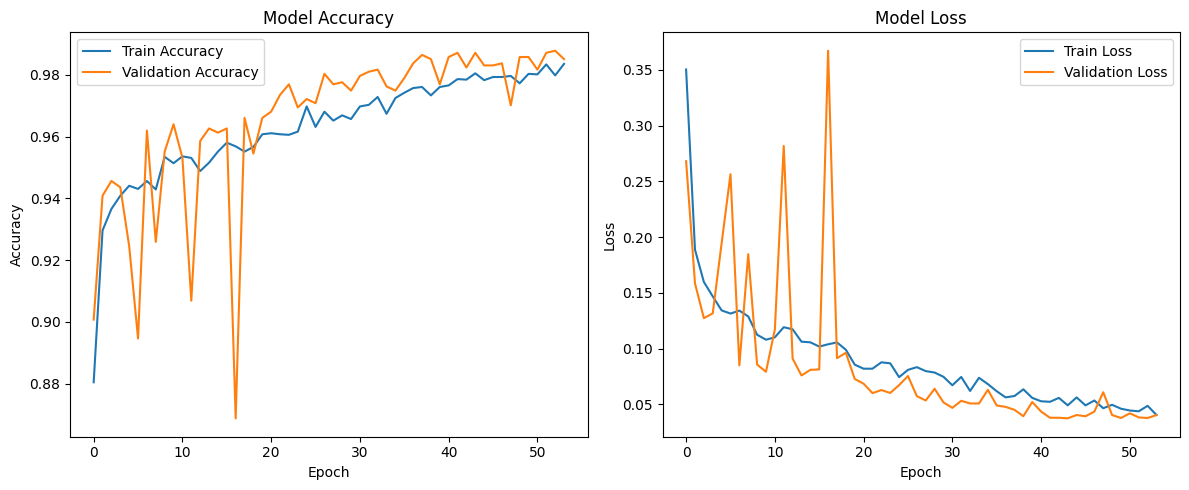

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
test_loss, test_acc = model.evaluate(x_test_seq, y_test_seq_onehot)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_pred_proba = model.predict(x_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_seq_onehot, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9269 - loss: 0.2988
Test accuracy: 0.9505
Test loss: 0.2226
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


In [36]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 1]}): {spec:.4f}")


Evaluation Metrics:
Accuracy: 0.9505
Precision: 0.9529
Recall: 0.9505
F1 Score: 0.9501
Average Specificity: 0.9900

Class-wise Specificities:
Class 0 (WALKING): 0.9918
Class 1 (WALKING_UPSTAIRS): 0.9988
Class 2 (WALKING_DOWNSTAIRS): 0.9953
Class 3 (SITTING): 0.9914
Class 4 (STANDING): 0.9631
Class 5 (LAYING): 0.9996


In [37]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                           target_names=activity_labels['class_name'].values))


Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.96      1.00      0.98       496
  WALKING_UPSTAIRS       0.99      0.94      0.97       471
WALKING_DOWNSTAIRS       0.97      0.99      0.98       420
           SITTING       0.95      0.81      0.88       491
          STANDING       0.85      0.96      0.90       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



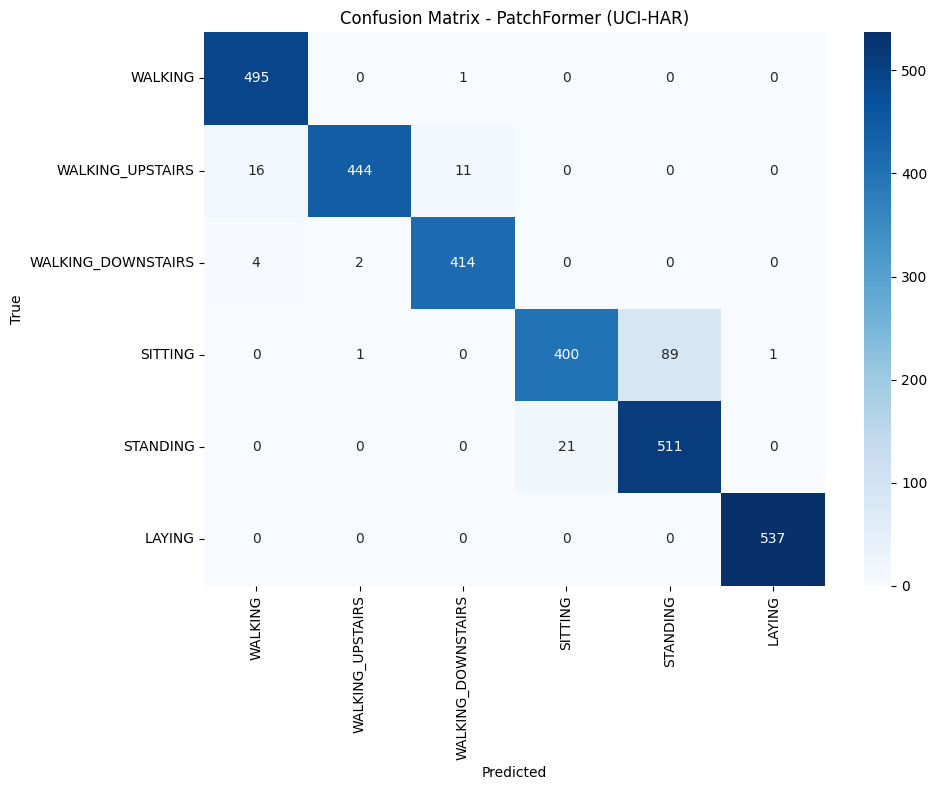

In [38]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()